In [1]:
import torch
import cv2
import numpy as np

def read_mp4_to_numpy(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)

    cap.release()
    return np.array(frames)  # Shape: (num_frames, height, width, channels)



In [86]:
for j, attn_k in enumerate([attn_1, attn_2]):
    img_arr = []
    for i in range(44):
        dpi = 100
        fig, ax = plt.subplots(dpi=dpi)
        ax.imshow(attn_k[i], vmin=0.0, vmax=0.01, interpolation='nearest')
        ax.axis('off')
        fig.tight_layout(pad=0)  # Remove padding between the figure and the edges
        fig.canvas.draw()
        image_array = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        image_array = image_array.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        plt.close(fig)
        img_arr.append(image_array)
    height, width, channels = img_arr[0].shape
    # Define the codec and create a VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # 'mp4v' for MP4 format
    out = cv2.VideoWriter(f'output_{j}.mp4', fourcc, 10, (width, height))
    for img in img_arr:
        out.write(img)  # Write each image to the video
    out.release()  # Release the writer

/tmp/ipykernel_2370769/2723861953.py:10: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  image_array = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


In [16]:
import tqdm
import matplotlib.pyplot as plt
model = 'twinvla_tabletop_bimanual_12'
num = 0
attn = torch.load(f'rollouts/2025_02_05/sim_transfer_cube/{model}/attns/attns_weights_{num}.pt').cpu().float()
print(attn.shape)
wid = attn.shape[-2] // 2
attn_1 = attn[:, :, :, wid-1, wid:]
attn_2 = attn[:, :, :, -1, :wid]
attn_0 = attn[:, :, :, wid-1, :wid]
attn_3 = attn[:, :, -1, wid:]
attn_avg_0 = []
attn_avg_1 = []
attn_avg_2 = []
attn_avg_3 = []

# Example Usage
video_dir = 'rollouts/2025_02_05/sim_transfer_cube/twinvla_tabletop_bimanual_12/videos/2025_02_05-14_48_56--episode=0--success=False--task=sim_transfer_cube.mp4'
video_array = read_mp4_to_numpy(video_dir)
width = video_array[0].shape[1]
height = video_array[0].shape[0]
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # 'mp4v' for MP4 format
out = cv2.VideoWriter(f'output_{model}_{num}_cube.mp4', fourcc, 20, (width, height))
for i in tqdm.tqdm(range(len(video_array)-1)):
    idx = i // 8
    attn_0_i = attn_0[idx]
    attn_1_i = attn_1[idx]
    attn_2_i = attn_2[idx]
    attn_3_i = attn_3[idx]
    attn_avg_0.append((attn_0_i.mean()).cpu().float().numpy())
    attn_avg_1.append((attn_1_i.mean()).cpu().float().numpy())
    attn_avg_2.append((attn_2_i.mean()).cpu().float().numpy())
    attn_avg_3.append((attn_3_i.mean()).cpu().float().numpy())

    # print(attn_avg_1[-1], attn_avg_2[-1])

    dpi = 100
    fig, ax = plt.subplots(figsize=(4, 1), dpi=100)
    # plt.plot(attn_avg_0, label='0')
    plt.plot(attn_avg_1, label='left refer right')
    plt.plot(attn_avg_2, label='right refer left')
    # ax.plot(values[:i+1], color='red', linewidth=2)  # Plot up to current frame
    ax.set_xlim(0, len(video_array)-1)  # Fixed x-axis
    # ax.set_ylim(min(values), max(values))  # Y축 고정
    # ax.set_ylim(min(values), max(values))  # Fixed y-axis
    ax.axis('off')
    fig.canvas.draw()
    graph_image = np.array(fig.canvas.renderer.buffer_rgba())[:, 20:-20]
    graph_h, graph_w, _ = graph_image.shape
    graph_resized = cv2.resize(graph_image, (width, height // 4))  # Resize graph

    # Convert RGBA to BGR for OpenCV
    graph_resized = cv2.cvtColor(graph_resized, cv2.COLOR_RGBA2BGR)

    video_array[i, -graph_resized.shape[0]:, -graph_resized.shape[1]:] = graph_resized
    out.write(video_array[i])
    plt.close(fig)
out.release()

torch.Size([57, 24, 16, 412, 412])


100%|██████████████████████████████████████████| 449/449 [00:28<00:00, 15.78it/s]


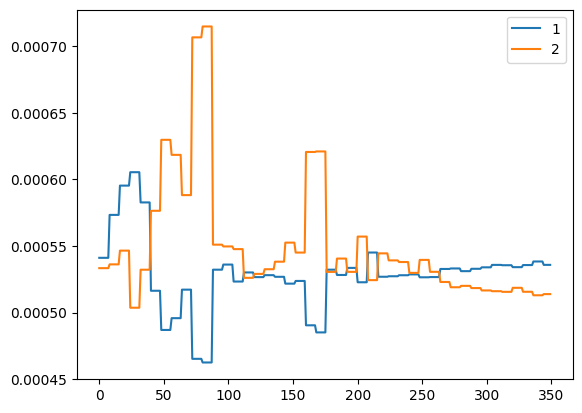

In [91]:
import matplotlib.pyplot as plt
# plt.plot(attn_avg_0, label='0')
plt.plot(attn_avg_1, label='1')
plt.plot(attn_avg_2, label='2')
# plt.plot(attn_avg_3, label='3')
plt.legend()
plt.show()

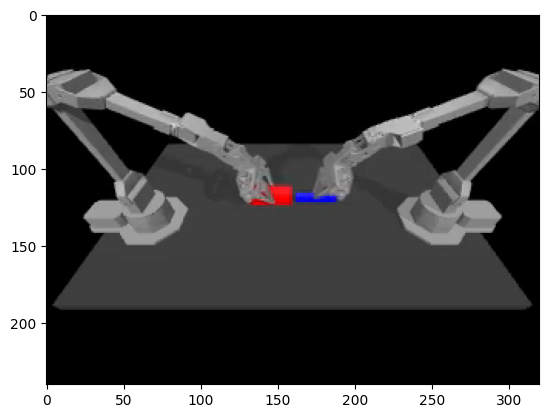

In [79]:
plt.imshow(video_array[300])